<a href="https://colab.research.google.com/github/DataAnalystPL/Data_analysis/blob/main/Chicago_Taxi_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chicago taxi services in 2022


## 1. Installation and import of Packages

In [2]:
#!nvidia-smi

In [3]:
#!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
#!python rapidsai-csp-utils/colab/pip-install.py

In [4]:
#pip install pyarrow==12.0.0

In [5]:
import cudf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import folium

## 2. Connecting to database

Data source: https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz

In [6]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
file_path = '/content/drive/MyDrive/Taxi/Taxi_Trips_-_2022_20231107.csv'

In [8]:
df = cudf.read_csv(file_path)

## 3. Basic EDA

In [9]:
# First 5 rows of the dataset:
df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,bcfa19f2539021c054809d4c3993d226996ae095,368ce5511598af2cc07efdb68067d381174fdac1d47a28...,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,152,0.10,<NA>,<NA>,<NA>,<NA>,...,0.0,3.75,Cash,Medallion Leasin,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,2aba69ff015f9ea8e7bff43cab7eddb228f34a12,449fa4909552757130d09d98ebc7770e2dd94579036b0e...,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2360,17.44,<NA>,<NA>,<NA>,8,...,5.0,52.75,Cash,Flash Cab,<NA>,<NA>,<NA>,41.89960211,-87.63330804,POINT (-87.6333080367 41.899602111)
2,54d812a0b88f8f9707825261014b3563a0a60ace,f98ae5e71fdda8806710af321dce58002146886c013f41...,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,536,4.83,<NA>,<NA>,28,22,...,0.0,14.75,Cash,Globe Taxi,41.87400538,-87.66351755,POINT (-87.6635175498 41.874005383),41.92276062,-87.69915534,POINT (-87.6991553432 41.9227606205)
3,7125b9e03a0f16c2dfb5eaf73ed057dc51eb68ef,8eca35a570101ad24c638f1f43eecce9d0cb7843e13a75...,01/01/2022 12:00:00 AM,01/01/2022 12:15:00 AM,897,2.07,<NA>,<NA>,8,32,...,1.5,11.25,Cash,Sun Taxi,41.89960211,-87.63330804,POINT (-87.6333080367 41.899602111),41.87886558,-87.62519214,POINT (-87.6251921424 41.8788655841)
4,f1a650ee419b4e52d766432e6f86eca3457bfb37,e2d8418fcdb061eee0a4318fba0a6a1200aaff0143feb0...,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2200,2.48,<NA>,<NA>,8,32,...,0.0,11.50,Mobile,Chicago Independents,41.89960211,-87.63330804,POINT (-87.6333080367 41.899602111),41.87886558,-87.62519214,POINT (-87.6251921424 41.8788655841)


In [10]:
df.shape

(6382425, 23)

In [11]:
# Summary statistics
df.describe(datetime_is_numeric=True)

,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
count,6.380960e+06,6.382369e+06,2.623831e+06,2.675331e+06,5.868572e+06,5.748741e+06,6.378889e+06,6.378889e+06,6.378889e+06,6.378889e+06,6.378889e+06,5.870874e+06,5.870874e+06,5.784494e+06,5.784494e+06
mean,1.198209e+03,6.185569e+00,1.703147e+10,1.703141e+10,3.235048e+01,2.584317e+01,2.172931e+01,2.754555e+00,2.128400e-02,2.163036e+00,2.682510e+01,4.189992e+01,-8.768816e+01,4.189471e+01,-8.766249e+01
std,1.895665e+03,8.002858e+00,3.689458e+05,3.457735e+05,2.520304e+01,2.092543e+01,4.941624e+01,4.083892e+00,7.659939e+00,2.175269e+01,5.696460e+01,6.015100e-02,1.047000e-01,5.620700e-02,7.332000e-02
min,0.000000e+00,0.000000e+00,1.703101e+10,1.703101e+10,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.165192e+01,-8.791362e+01,4.166014e+01,-8.791362e+01
25%,4.580000e+02,8.500000e-01,1.703108e+10,1.703108e+10,8.000000e+00,8.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.990000e+00,4.187887e+01,-8.768384e+01,4.187887e+01,-8.766352e+01
50%,8.620000e+02,2.600000e+00,1.703132e+10,1.703132e+10,3.200000e+01,2.800000e+01,1.400000e+01,9.200000e-01,0.000000e+00,0.000000e+00,1.700000e+01,4.189322e+01,-8.763331e+01,4.189251e+01,-8.763331e+01
75%,1.620000e+03,1.110000e+01,1.703184e+10,1.703184e+10,4.400000e+01,3.200000e+01,3.325000e+01,4.000000e+00,0.000000e+00,2.000000e+00,4.050000e+01,4.194423e+01,-8.762519e+01,4.192269e+01,-8.762519e+01
max,8.634100e+04,2.967540e+03,1.703198e+10,1.703198e+10,7.700000e+01,7.700000e+01,9.999750e+03,4.960000e+02,6.666660e+03,8.888880e+03,9.999750e+03,4.202122e+01,-8.753071e+01,4.202122e+01,-8.753139e+01


In [12]:
# Data types of each column
df.dtypes

Trip ID                        object
Taxi ID                        object
Trip Start Timestamp           object
Trip End Timestamp             object
Trip Seconds                    int64
Trip Miles                    float64
Pickup Census Tract             int64
Dropoff Census Tract            int64
Pickup Community Area           int64
Dropoff Community Area          int64
Fare                          float64
Tips                          float64
Tolls                         float64
Extras                        float64
Trip Total                    float64
Payment Type                   object
Company                        object
Pickup Centroid Latitude      float64
Pickup Centroid Longitude     float64
Pickup Centroid Location       object
Dropoff Centroid Latitude     float64
Dropoff Centroid Longitude    float64
Dropoff Centroid  Location     object
dtype: object

In [13]:
# Number of missing values in each column
df.isnull().sum()

Trip ID                             0
Taxi ID                           354
Trip Start Timestamp                0
Trip End Timestamp                212
Trip Seconds                     1465
Trip Miles                         56
Pickup Census Tract           3758594
Dropoff Census Tract          3707094
Pickup Community Area          513853
Dropoff Community Area         633684
Fare                             3536
Tips                             3536
Tolls                            3536
Extras                           3536
Trip Total                       3536
Payment Type                        0
Company                             0
Pickup Centroid Latitude       511551
Pickup Centroid Longitude      511551
Pickup Centroid Location       511551
Dropoff Centroid Latitude      597931
Dropoff Centroid Longitude     597931
Dropoff Centroid  Location     597931
dtype: int64

## 4. Cleaning Dataset of missing values

In [14]:
# Droping empty and columns with 0 values or useless
col_to_drop = ["Pickup Census Tract", "Dropoff Census Tract", "Pickup Centroid Location" , "Dropoff Centroid  Location"]
df.drop(col_to_drop, axis=1, inplace=True)

In [15]:
columns_to_clean = ['Taxi ID', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Fare', 'Tips', 'Extras', 'Trip Total', 'Tolls']
# Droping empty rows
for column in columns_to_clean:
  df.dropna(subset=column, inplace=True)

In [16]:
df.isnull().sum()

Trip ID                            0
Taxi ID                            0
Trip Start Timestamp               0
Trip End Timestamp                 0
Trip Seconds                       0
Trip Miles                         0
Pickup Community Area         512639
Dropoff Community Area        632344
Fare                               0
Tips                               0
Tolls                              0
Extras                             0
Trip Total                         0
Payment Type                       0
Company                            0
Pickup Centroid Latitude      510345
Pickup Centroid Longitude     510345
Dropoff Centroid Latitude     596625
Dropoff Centroid Longitude    596625
dtype: int64

As seen some Dropoff and Pickup areas are missing but we have Latitude and Longitude of those missing points. I will later try to find those area numbers based on coordinates.

**According to dataset description empty pickup and drop-off points mean that the points were outside Chicago borders.**

# 5. Cleaning timestamps

In [17]:
df['Trip Start Timestamp'] = cudf.to_datetime(df['Trip Start Timestamp'], format='%m/%d/%Y %I:%M:%S %p').dt.strftime('%Y-%m-%d %H:%M:%S')
df['Trip End Timestamp'] = cudf.to_datetime(df['Trip End Timestamp'], format='%m/%d/%Y %I:%M:%S %p').dt.strftime('%Y-%m-%d %H:%M:%S')

## 5. EDA

In [18]:
import matplotlib
matplotlib.style.use('ggplot')

In [19]:
palette = ['#367C6E', '#EECD69', '#F3AC59', '#954C41', '#E56F3E']

### 1. Taxi Companies info

In [20]:
#How many taxi companies do we have in the database?
taxi_companies = df['Company'].unique().to_pandas()

In [21]:
taxi_companies

0                         Medallion Leasin
1                                Flash Cab
2                               Globe Taxi
3                                 Sun Taxi
4                     Chicago Independents
5                             City Service
6                Taxi Affiliation Services
7                      Top Cab Affiliation
8                  Choice Taxi Association
9            Taxicab Insurance Agency, LLC
10                           24 Seven Taxi
11    Patriot Taxi Dba Peace Taxi Associat
12       Blue Ribbon Taxi Association Inc.
13                               U Taxicab
14                              Setare Inc
15           312 Medallion Management Corp
16                   KOAM Taxi Association
17                         Chicago Taxicab
18                         Petani Cab Corp
19                 2733 - 74600 Benny Jona
20         3620 - 52292 David K. Cab Corp.
21                       Metro Jet Taxi A.
22             3556 - 36214 RC Andrews Cab
23         

Some Companies are doubled!

In [22]:
df['Company'] = df['Company'].replace('KOAM Taxi Association','Koam Taxi Association')

In [23]:
df['Company'] = df['Company'].replace('Taxicab Insurance Agency, LLC', 'Taxicab Insurance Agency Llc')

In [24]:
taxi_companies = df['Company'].unique().to_pandas() #Let's check again how many unique taxis are in database

In [25]:
print(f"We have {len(taxi_companies)} taxi companies:")
for row in taxi_companies:
  print("\t- ", row)

We have 35 taxi companies:
	-  Medallion Leasin
	-  Flash Cab
	-  Globe Taxi
	-  Sun Taxi
	-  Chicago Independents
	-  City Service
	-  Taxi Affiliation Services
	-  Top Cab Affiliation
	-  Choice Taxi Association
	-  Taxicab Insurance Agency Llc
	-  24 Seven Taxi
	-  Patriot Taxi Dba Peace Taxi Associat
	-  Blue Ribbon Taxi Association Inc.
	-  U Taxicab
	-  Setare Inc
	-  312 Medallion Management Corp
	-  Koam Taxi Association
	-  Chicago Taxicab
	-  Petani Cab Corp
	-  2733 - 74600 Benny Jona
	-  3620 - 52292 David K. Cab Corp.
	-  Metro Jet Taxi A.
	-  3556 - 36214 RC Andrews Cab
	-  4053 - 40193 Adwar H. Nikola
	-  4787 - 56058 Reny Cab Co
	-  Chicago Carriage Cab Corp
	-  Top Cab
	-  6574 - Babylon Express Inc.
	-  4623 - 27290 Jay Kim
	-  Nova Taxi Affiliation Llc
	-  Blue Ribbon Taxi Association
	-  Star North Taxi Management Llc
	-  5062 - 34841 Sam Mestas
	-  5 Star Taxi
	-  Leonard Cab Co


In [26]:
taxi_per_company = df.groupby('Company')['Taxi ID'].nunique().sort_values(ascending=False).to_pandas()
print(taxi_per_company)

Company
Flash Cab                               586
Taxi Affiliation Services               549
Taxicab Insurance Agency Llc            352
5 Star Taxi                             342
Sun Taxi                                313
City Service                            291
Chicago Independents                    203
Medallion Leasin                        146
Blue Ribbon Taxi Association            123
Globe Taxi                              121
Star North Taxi Management Llc          102
Blue Ribbon Taxi Association Inc.        84
Choice Taxi Association                  67
Top Cab Affiliation                      65
24 Seven Taxi                            36
U Taxicab                                34
Chicago Taxicab                          17
Patriot Taxi Dba Peace Taxi Associat     11
312 Medallion Management Corp             9
Koam Taxi Association                     8
Top Cab                                   7
Petani Cab Corp                           5
Chicago Carriage Cab Cor

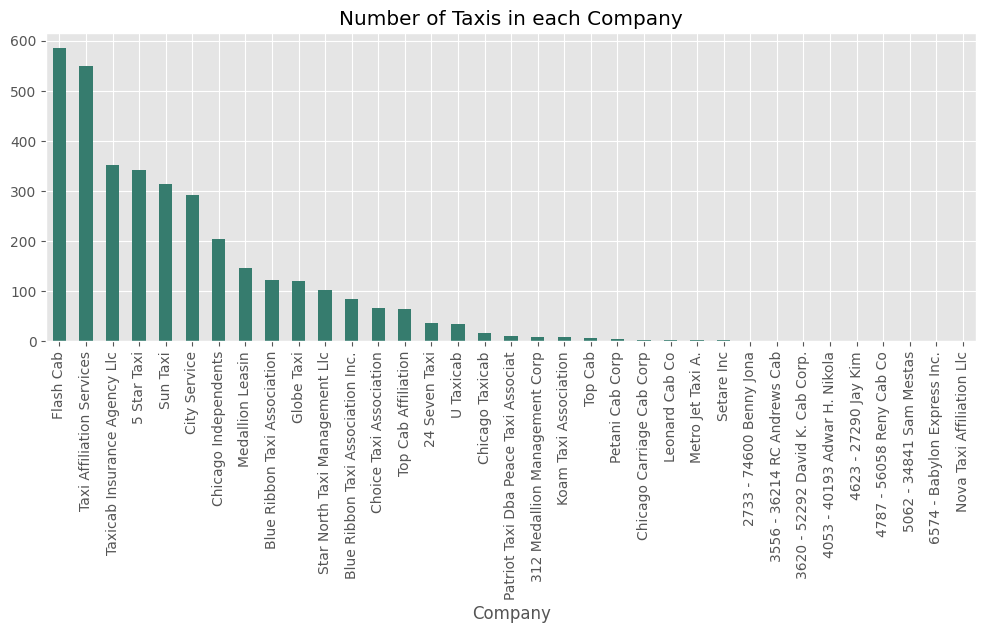

In [27]:
taxi_per_company.plot(kind='bar', figsize=(12,4), title='Number of Taxis in each Company', color=palette[0])
plt.show()

In [28]:
#How many Trips each company made?
trip_count_by_company = df.groupby('Company').size().sort_values(ascending=False).to_pandas()
print(trip_count_by_company)

Company
Flash Cab                               1406011
Taxi Affiliation Services               1325524
Sun Taxi                                 717838
City Service                             587808
Taxicab Insurance Agency Llc             549078
Chicago Independents                     328276
Medallion Leasin                         266165
Globe Taxi                               241804
5 Star Taxi                              157786
Star North Taxi Management Llc           152557
Blue Ribbon Taxi Association             151942
Choice Taxi Association                  126597
Top Cab Affiliation                      108904
U Taxicab                                 57818
24 Seven Taxi                             55929
Blue Ribbon Taxi Association Inc.         36977
Chicago Taxicab                           24149
Patriot Taxi Dba Peace Taxi Associat      21823
Koam Taxi Association                     18985
312 Medallion Management Corp              9965
Setare Inc                      

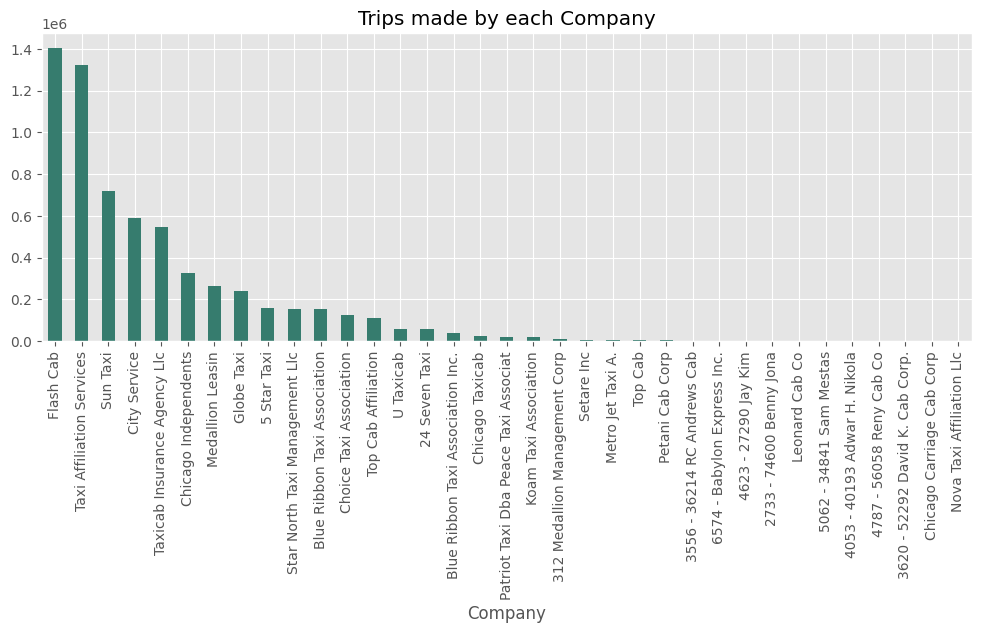

In [29]:
trip_count_by_company.plot(kind='bar', figsize=(12,4), title='Trips made by each Company', color=palette[0])
plt.show()

In [30]:
trip_details_columns = ['Trip Miles', 'Trip Seconds', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total']

Miles made by each Company
Company
Flash Cab                               9141929.80
Taxi Affiliation Services               5342499.00
Sun Taxi                                4992774.31
City Service                            4127291.59
Taxicab Insurance Agency Llc            3603497.49
Chicago Independents                    2304801.71
Medallion Leasin                        1834841.96
Globe Taxi                              1592866.65
Star North Taxi Management Llc          1153955.45
5 Star Taxi                             1092898.57
Choice Taxi Association                  915624.50
Blue Ribbon Taxi Association             900933.74
Top Cab Affiliation                      774387.20
U Taxicab                                481574.50
24 Seven Taxi                            303277.23
Chicago Taxicab                          193022.68
Blue Ribbon Taxi Association Inc.        130847.40
Koam Taxi Association                    114810.40
Patriot Taxi Dba Peace Taxi Associat      91810

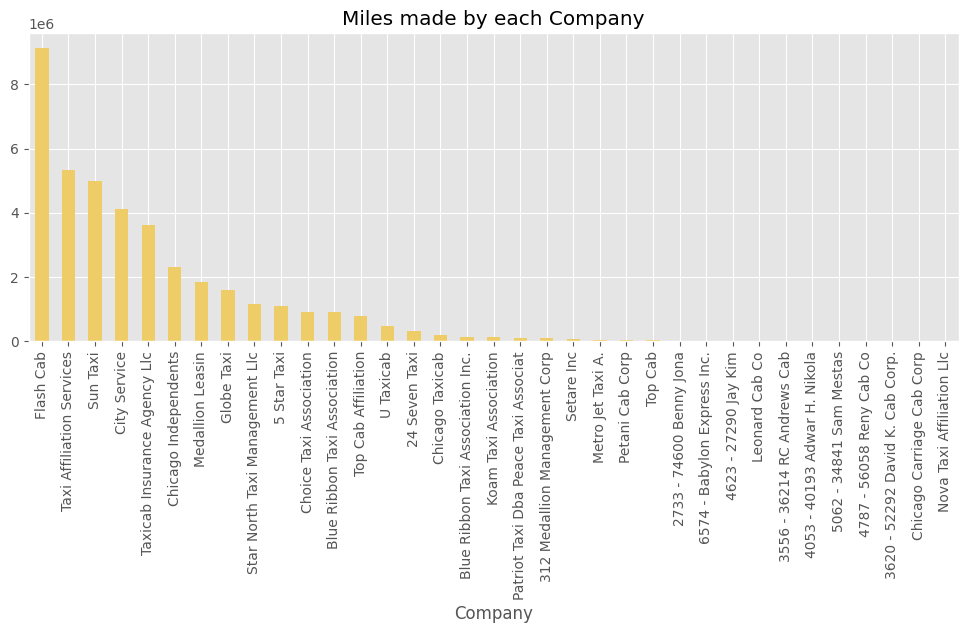

Sum of time in Trip by each Company
Company
Flash Cab                               1745823189
Taxi Affiliation Services               1452785400
Sun Taxi                                 927939159
City Service                             698913987
Taxicab Insurance Agency Llc             637452000
Chicago Independents                     391203207
Medallion Leasin                         331038128
Globe Taxi                               285589201
5 Star Taxi                              216129791
Star North Taxi Management Llc           200597950
Blue Ribbon Taxi Association             175339160
Choice Taxi Association                  152929920
Top Cab Affiliation                      129353460
U Taxicab                                 76006440
24 Seven Taxi                             55223148
Chicago Taxicab                           32898289
Blue Ribbon Taxi Association Inc.         32202300
Patriot Taxi Dba Peace Taxi Associat      24103375
Koam Taxi Association                 

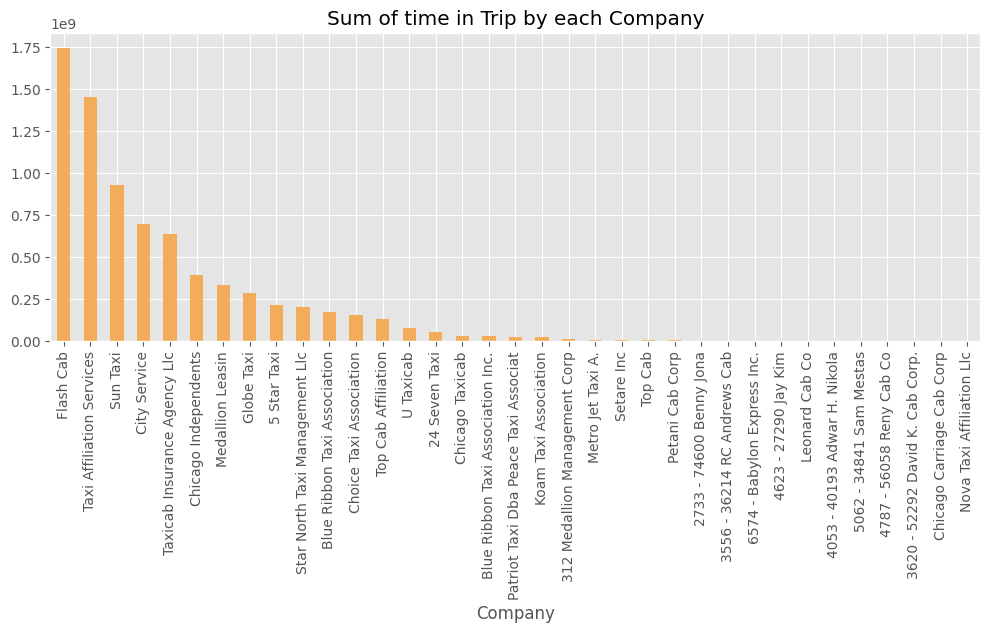

Income from Fare by each Company
Company
Flash Cab                               30802118.03
Taxi Affiliation Services               27346035.87
Sun Taxi                                15414653.15
City Service                            12681291.80
Taxicab Insurance Agency Llc            11940460.76
Chicago Independents                     7137337.46
Medallion Leasin                         5561937.06
Globe Taxi                               5027314.32
5 Star Taxi                              3627267.17
Star North Taxi Management Llc           3461799.03
Blue Ribbon Taxi Association             2932966.39
Choice Taxi Association                  2760115.19
Top Cab Affiliation                      2326319.54
Metro Jet Taxi A.                        2212204.06
U Taxicab                                1411798.95
24 Seven Taxi                             992593.47
Chicago Taxicab                           690053.05
Blue Ribbon Taxi Association Inc.         598761.24
Patriot Taxi Dba Peace 

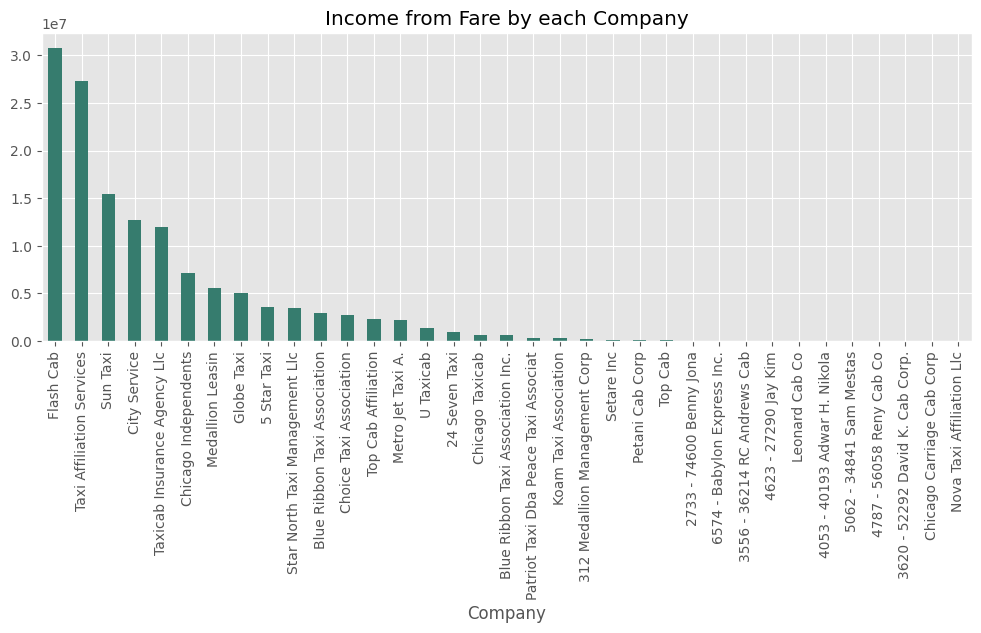

Income from Tips by each Company
Company
Taxi Affiliation Services               3201435.09
Sun Taxi                                2536052.21
Flash Cab                               2404646.22
City Service                            1921108.84
Taxicab Insurance Agency Llc            1847773.41
Chicago Independents                    1189322.13
Medallion Leasin                         816999.15
Globe Taxi                               748991.87
Star North Taxi Management Llc           530112.58
5 Star Taxi                              454378.89
Choice Taxi Association                  431398.38
Blue Ribbon Taxi Association             372077.93
Top Cab Affiliation                      365878.94
U Taxicab                                205270.80
24 Seven Taxi                            163754.82
Chicago Taxicab                           81682.09
Blue Ribbon Taxi Association Inc.         61907.23
Koam Taxi Association                     59862.67
312 Medallion Management Corp            

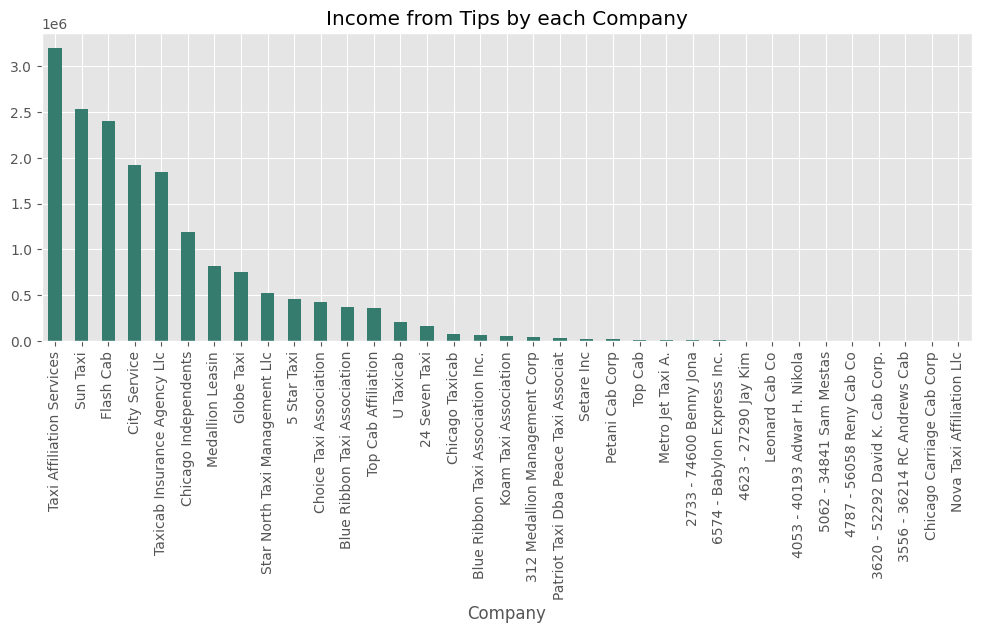

Income from Tolls by each Company
Company
Taxi Affiliation Services               91503.71
Taxicab Insurance Agency Llc            13953.85
Chicago Independents                     5012.38
Sun Taxi                                 3806.21
City Service                             3729.77
Star North Taxi Management Llc           3380.92
Globe Taxi                               3362.68
Medallion Leasin                         3023.96
Choice Taxi Association                  2919.98
Top Cab Affiliation                      1766.26
U Taxicab                                1612.35
Blue Ribbon Taxi Association             1360.17
Koam Taxi Association                     155.06
Chicago Taxicab                            54.52
Flash Cab                                  43.75
5 Star Taxi                                37.00
Petani Cab Corp                            15.00
Top Cab                                    15.00
312 Medallion Management Corp              14.50
Metro Jet Taxi A.          

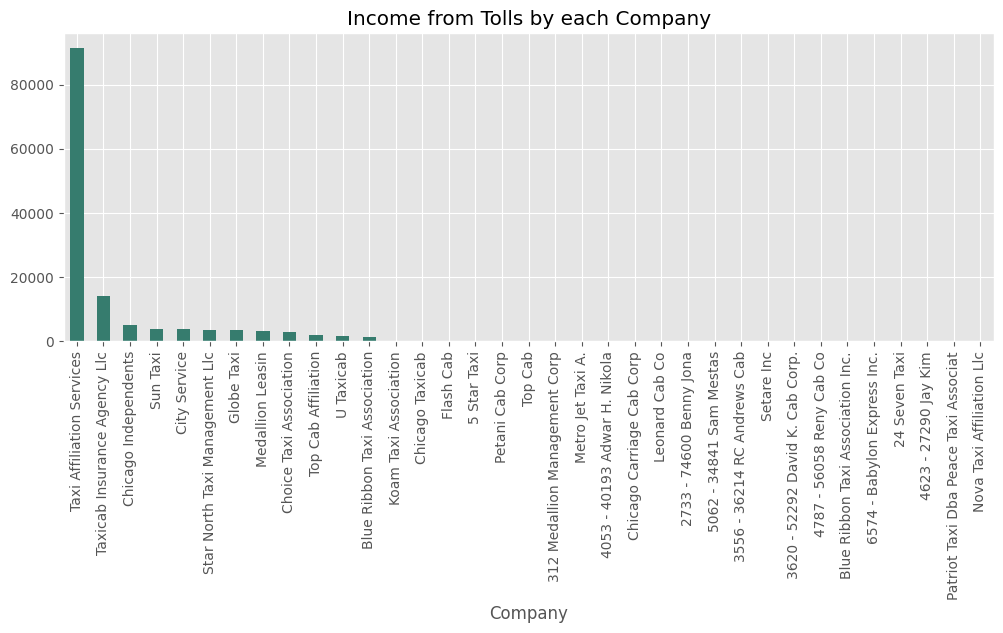

Income from Extras by each Company
Company
Taxi Affiliation Services               3527614.60
Sun Taxi                                1598401.02
Flash Cab                               1577990.50
Taxicab Insurance Agency Llc            1515252.80
City Service                            1218211.05
Chicago Independents                     843392.47
Medallion Leasin                         652972.53
Globe Taxi                               545455.87
Star North Taxi Management Llc           402662.65
Choice Taxi Association                  360685.14
Top Cab Affiliation                      355218.63
5 Star Taxi                              340059.00
Blue Ribbon Taxi Association             215540.47
U Taxicab                                205694.26
24 Seven Taxi                             82883.50
Chicago Taxicab                           81504.32
Blue Ribbon Taxi Association Inc.         59823.56
312 Medallion Management Corp             44455.51
Koam Taxi Association                  

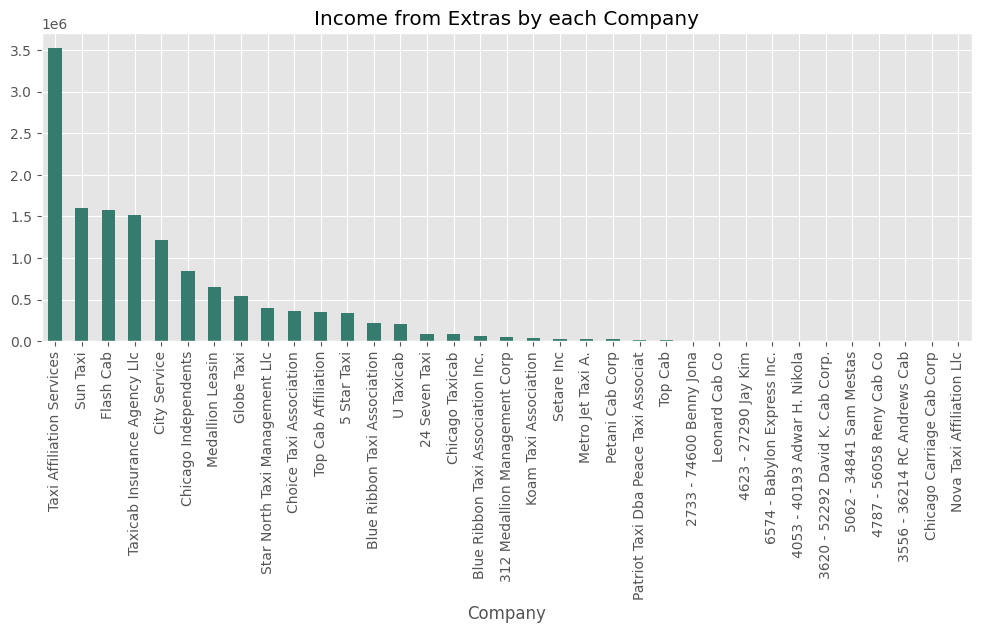

Income from Trip Total by each Company
Company
Flash Cab                               34966842.88
Taxi Affiliation Services               34166589.87
Sun Taxi                                19762369.82
City Service                            15981140.10
Taxicab Insurance Agency Llc            15404639.51
Chicago Independents                     9258593.44
Medallion Leasin                         7108685.83
Globe Taxi                               6383624.87
5 Star Taxi                              4456874.14
Star North Taxi Management Llc           4443057.83
Blue Ribbon Taxi Association             3559929.69
Choice Taxi Association                  3555118.69
Top Cab Affiliation                      3049183.37
Metro Jet Taxi A.                        2247536.43
U Taxicab                                1824376.36
24 Seven Taxi                            1252914.89
Chicago Taxicab                           860203.76
Blue Ribbon Taxi Association Inc.         720492.03
Koam Taxi Associa

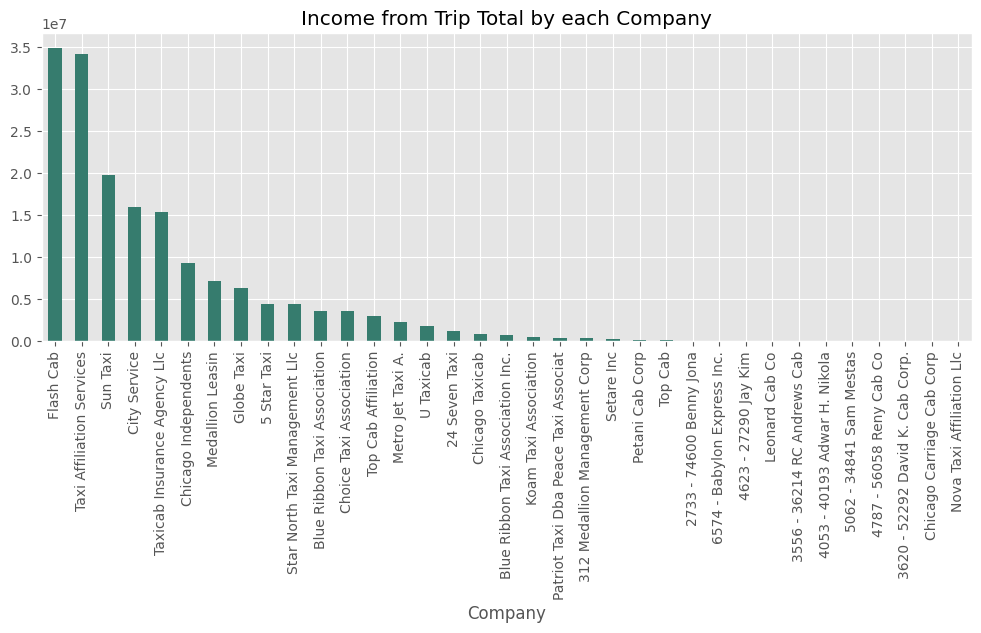

In [31]:
for feat in trip_details_columns:
  details = df.groupby('Company')[feat].sum().sort_values(ascending=False).to_pandas()
  if feat == 'Trip Miles':
    print('\033[1mMiles made by each Company\033[0m')
    print(details.round(2))
    details.plot(kind='bar', figsize=(12,4), title='Miles made by each Company', color=palette[1])
    plt.show()
  elif feat == 'Trip Seconds':
    print('\033[1mSum of time in Trip by each Company\033[0m')
    print(details.round(2))
    details.plot(kind='bar', figsize=(12,4), title='Sum of time in Trip by each Company', color=palette[2])
    plt.show()
  else:
    print(f"\033[1mIncome from {feat} by each Company\033[0m")
    print(details.round(2))
    details.plot(kind='bar', figsize=(12,4), title=f'Income from {feat} by each Company', color=palette[0])
    plt.show()


**Observations**


*   Tolls and Extras has probably some outliers
*   There are couple Taxi companies which have only 1 driver
*   Flash Cab and Taxi Affiliation Services are the largest Taxi companies in Chicago



### 2. Taxi Drivers info

In [32]:
#How many taxis do we have in the database and how many trips make each one?
trip_count_by_taxi = df.groupby(['Taxi ID']).size().sort_values(ascending=False).to_pandas()

In [33]:
print(f"We have {len(trip_count_by_taxi)} taxis and the most active one made {trip_count_by_taxi.max()} trips")

We have 2950 taxis and the most active one made 10056 trips


Miles made by each Taxi
Taxi ID
da60c0b2a94e4c516b9c9bdaceeb3f17066f98190eb3895010b6071915a64752e5cb1532dc6d36f992a6ed48287e4409110651d140ba63296c1f68f0ed853676    69085.31
a79d72d3d49bed13558577cc0608caf7e8da5b9cee67b608b53567d1be89e0ad257654a59e271e1a0239e5ef4a926668d7edb9e1a798a7b1e6726b64113518c6    69075.91
950af3418bda33a809615e29c0592a6ab8ed5f479173437b80b129e16694d099c13ac649b93c38a08e703f3bc8c11a16bf7c37ccca96824dd06c56709d6afeac    61071.55
356744753023949fa63be6a6d7e0aef31f2d50dd3b0258449c6b8b6d277765da6955b1ef88c72ca79a9db0d3c20b162fce7cd9ec113b49da61c12c2c546915d4    59927.62
2981edd199f55bdc8b5ed188de69e9f5d8116ae8d7a434fa0574d57740840e697755e4e77bb4ce8265289b6548d53674a5ac16dde44c3cf653e3ce1c8e064265    57110.70
Name: Trip Miles, dtype: float64


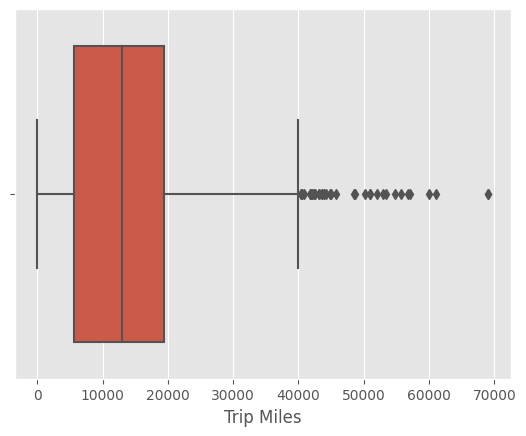

Sum of time in Trip by each Taxi
Taxi ID
c51a860a4716b6a9e4529f8270d895478e79b5369d3fc254fc657536794c8a75dcfe83a8c2c229da7aa26688ee6e949fc9d5e4461d6deb768021a63e99158432    18344958
175a4c9a16e22bfd2fee721e6cdfdc85dfde21cccb1fdcf514631f3719704bad1c82db8ff3320b8e305e11116bc8932a220910da15c991926772cca793bafd5c    17980613
63f04d77360d12a3b71ebabb82794a2cc1842a1f5a147cdfc2e32bdcb13b8b2c08024bbfad979af58aec7d7e3757798c04d31de086ad3831a02783bcd90001ee    11299993
502a000e4ee99c96dc9964f2994671b57b73fd6902e2342ce2c0a2964ccac777078c7f455e928fecd64cc01571af88a107fc0341b5a5b8cf2d5f06212d972cd9    10287009
22c06e3ec9587da0d7536065869f2da9965faf286be5837d6cc0472ba7098e51a103200268fec604e4da8fc8fdc604d877bd6be66ea74bb305e5efc749ce9d09    10102808
Name: Trip Seconds, dtype: int64


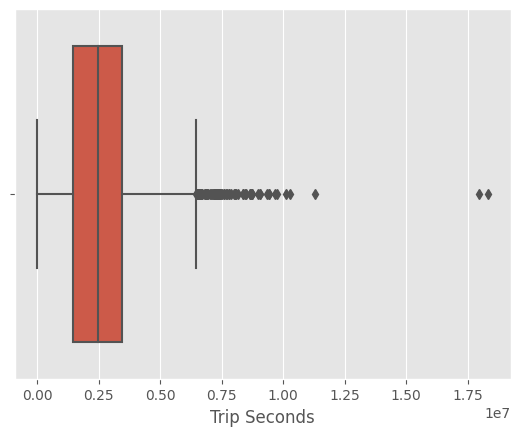

Income from Fare by each Taxi
Taxi ID
0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e17cf9d2667a71567625295b41d5553d75cf6cacdc81951d95dfcad84e414210f2e166ea07cca4197b3a    2162849.72
252ada1a45e512d3d038a61eb1832c0eec8e3c8dce58336f73d774bea49e0f203635dbc583d2135f060a5cd63c9ea7f6ac787f546ffa0b80daabd6e39eebe4f1     197171.80
356744753023949fa63be6a6d7e0aef31f2d50dd3b0258449c6b8b6d277765da6955b1ef88c72ca79a9db0d3c20b162fce7cd9ec113b49da61c12c2c546915d4     196760.74
222a0a55fe5180e292a8e128804e081fa50b05a0329775f9344b50ee230f23d12635ee6a2429af764d01221057af04260089849cfb0192fa29bfda38362ffad6     194410.60
da60c0b2a94e4c516b9c9bdaceeb3f17066f98190eb3895010b6071915a64752e5cb1532dc6d36f992a6ed48287e4409110651d140ba63296c1f68f0ed853676     189348.12
Name: Fare, dtype: float64


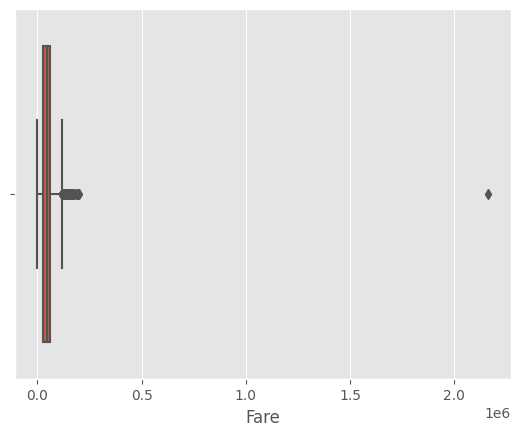

Income from Tips by each Taxi
Taxi ID
847cf962bd6f62040673e6c24c24940aeb2d7fdaa54677eed6a0aaa4aeef61984916b32d763b4baa6c32476531543bb77e2346cd64f505618f6b9d562243f950    34247.45
252ada1a45e512d3d038a61eb1832c0eec8e3c8dce58336f73d774bea49e0f203635dbc583d2135f060a5cd63c9ea7f6ac787f546ffa0b80daabd6e39eebe4f1    26227.11
f98ae5e71fdda8806710af321dce58002146886c013f411be2cd336e0c224e78ed85626eeee462f0d1f5e6b29a030514b95f7b1b8ca59888a10b52dfe55ddf99    20766.23
509476ab6ed3f69bed54dcde037df74912a813e77d8fd8223c0325bbb94e911fd2132d798c98139b27f9ab2bc2a27304cb242d37ea10f79eb02396efc31c7294    19407.83
0cf1289b8acf557ac9673f1b9a4b544f295d83edb49af8429a57b45e0600bcfe523c7b2e8378b5b9a41550ee97cb33bc0b99ec7a73869f6e892e551bc4c2678e    18563.88
Name: Tips, dtype: float64


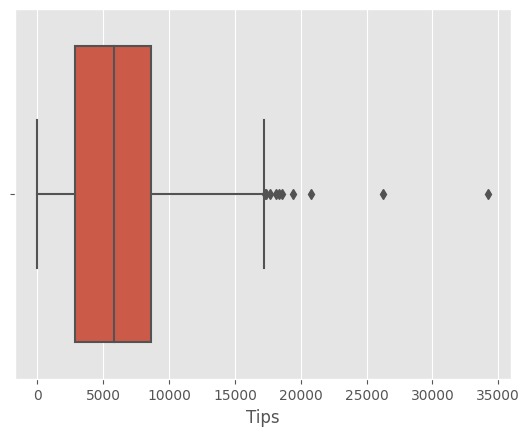

Income from Tolls by each Taxi
Taxi ID
53de0dbfc9e66a4ae663f3383fbbf41032653d04aa87007a3583585c3e79258d87ffb7cb342586f73aa690d69f51ad88ef29a3370b6d681ed78b5a20726d9ded    46662.24
46c4778c3a32454511f96752c509c608955e293da45dbf245bf9eba5bef28916b7b61295d27aa8f61e4ad63b264051057ace630bce41b8aff5bc6853585fed15     6667.98
43df1f84886471551da759b428112545e906f7652ee5b3426c1059a390ab1bc9f47c3de0dc58108b37143c1cef8148b4f44a3df57e17bd140e464df3fbab7482     5786.77
fbfc2ff558d0fc2dd96362ef65d25e08f00b13bc427645692cc034fb62d0ccf5f19c7187554fdf79c714323023b793de64da10de48051c38528f05ca5fc29e27     5558.47
3577d72a8bf30406c1346a5e178b7f3a0ce8e1f966f59afa6b9acfd4668b779e82f3766dd3b426278a666a18a9ae5d159070e7821e06c0c00ed390eca863e001     4570.72
Name: Tolls, dtype: float64


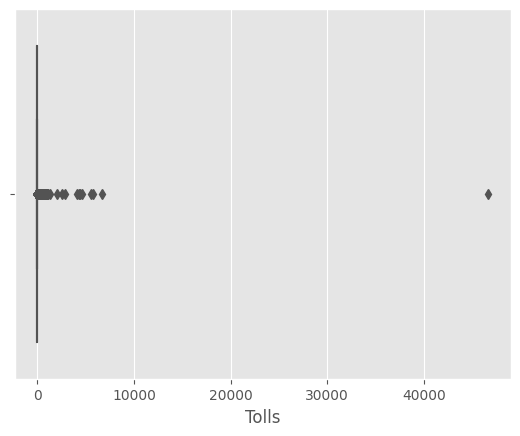

Income from Extras by each Taxi
Taxi ID
53de0dbfc9e66a4ae663f3383fbbf41032653d04aa87007a3583585c3e79258d87ffb7cb342586f73aa690d69f51ad88ef29a3370b6d681ed78b5a20726d9ded    238167.37
fea1ad3b44e1a049eb5b1f33d9c53ddd6cae02b095b6a16c8507d94624aab8dcfcaa2eb03f45242370f1dc88ce1f9fed5fff858de8ef863a30868f68a0626773     41232.36
fdc3156afe8accb70f5aea5f2cd2d7cefd089d13b6d930151e1a195fbb53b1caf1b110ebbb901077e295080c2a5a3e1b2d2b42595435d1defd965e1604c1cf90     33761.80
d6fd39863cdce99011c7282605bedf70d9d059ecf0da5e93242f3de6c55f79b8dfe37a4f5fbc09e022d9a1e7c5be50360aa1852d04f9e42695742191ccb25606     26501.56
82bc059c3b13e97341f941d60f772ae9f83687498e91f7c399644ec42449cced734834174cb0a29955229b910c3c9810dc67997226ce38a8600bf7f24d149423     26002.50
Name: Extras, dtype: float64


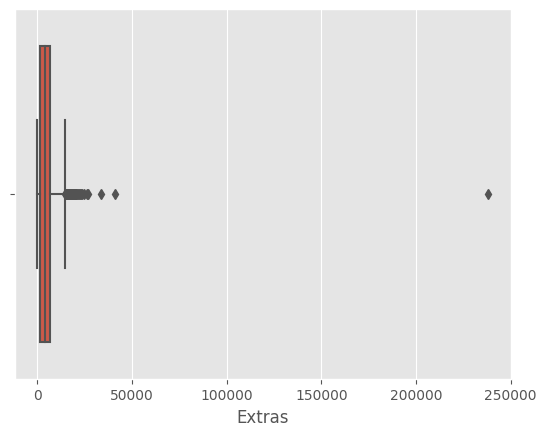

Income from Trip Total by each Taxi
Taxi ID
0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e17cf9d2667a71567625295b41d5553d75cf6cacdc81951d95dfcad84e414210f2e166ea07cca4197b3a    2188190.82
53de0dbfc9e66a4ae663f3383fbbf41032653d04aa87007a3583585c3e79258d87ffb7cb342586f73aa690d69f51ad88ef29a3370b6d681ed78b5a20726d9ded     372878.64
252ada1a45e512d3d038a61eb1832c0eec8e3c8dce58336f73d774bea49e0f203635dbc583d2135f060a5cd63c9ea7f6ac787f546ffa0b80daabd6e39eebe4f1     239433.74
222a0a55fe5180e292a8e128804e081fa50b05a0329775f9344b50ee230f23d12635ee6a2429af764d01221057af04260089849cfb0192fa29bfda38362ffad6     225558.14
356744753023949fa63be6a6d7e0aef31f2d50dd3b0258449c6b8b6d277765da6955b1ef88c72ca79a9db0d3c20b162fce7cd9ec113b49da61c12c2c546915d4     198205.46
Name: Trip Total, dtype: float64


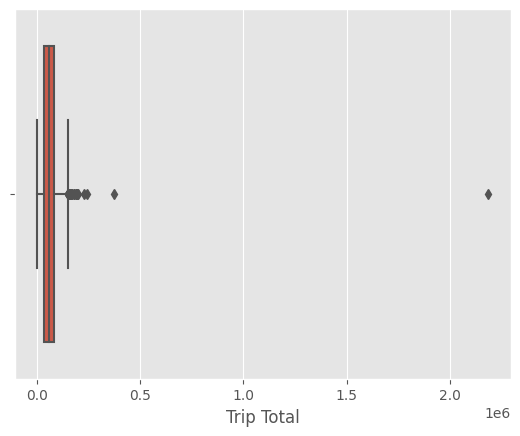

In [34]:
for feat in trip_details_columns:
  details = df.groupby('Taxi ID')[feat].sum().sort_values(ascending=False).to_pandas()
  if feat == 'Trip Miles':
    print('\033[1mMiles made by each Taxi\033[0m')
    print(details.round(2).head())
    sns.boxplot(x=details)
    plt.show()
  elif feat == 'Trip Seconds':
    print('\033[1mSum of time in Trip by each Taxi\033[0m')
    print(details.round(2).head())
    sns.boxplot(x=details)
    plt.show()
  else:
    print(f"\033[1mIncome from {feat} by each Taxi\033[0m")
    print(details.round(2).head())
    sns.boxplot(x=details)
    plt.show()

### 2a. Checking outliers in Fare, Tolls and Extras - TO DO

In [35]:
outliers_fare = df.groupby('Taxi ID')['Fare'].sum().sort_values(ascending=False)
outliers_fare.head(10)

Taxi ID
0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e17cf9d2667a71567625295b41d5553d75cf6cacdc81951d95dfcad84e414210f2e166ea07cca4197b3a    2162849.72
252ada1a45e512d3d038a61eb1832c0eec8e3c8dce58336f73d774bea49e0f203635dbc583d2135f060a5cd63c9ea7f6ac787f546ffa0b80daabd6e39eebe4f1     197171.80
356744753023949fa63be6a6d7e0aef31f2d50dd3b0258449c6b8b6d277765da6955b1ef88c72ca79a9db0d3c20b162fce7cd9ec113b49da61c12c2c546915d4     196760.74
222a0a55fe5180e292a8e128804e081fa50b05a0329775f9344b50ee230f23d12635ee6a2429af764d01221057af04260089849cfb0192fa29bfda38362ffad6     194410.60
da60c0b2a94e4c516b9c9bdaceeb3f17066f98190eb3895010b6071915a64752e5cb1532dc6d36f992a6ed48287e4409110651d140ba63296c1f68f0ed853676     189348.12
a79d72d3d49bed13558577cc0608caf7e8da5b9cee67b608b53567d1be89e0ad257654a59e271e1a0239e5ef4a926668d7edb9e1a798a7b1e6726b64113518c6     189130.59
f54427c55effd88638382dbec9828c89fd2580d13c166a073866fcc687db98a55b1b7a96b05669e887ca9ca72fef361546d4c5608c75b82afb62bd042e6d1489     1

In [36]:
outliers_tolls = df.groupby('Taxi ID')['Tolls'].sum().sort_values(ascending=False)
outliers_tolls.head(10)

Taxi ID
53de0dbfc9e66a4ae663f3383fbbf41032653d04aa87007a3583585c3e79258d87ffb7cb342586f73aa690d69f51ad88ef29a3370b6d681ed78b5a20726d9ded    46662.24
46c4778c3a32454511f96752c509c608955e293da45dbf245bf9eba5bef28916b7b61295d27aa8f61e4ad63b264051057ace630bce41b8aff5bc6853585fed15     6667.98
43df1f84886471551da759b428112545e906f7652ee5b3426c1059a390ab1bc9f47c3de0dc58108b37143c1cef8148b4f44a3df57e17bd140e464df3fbab7482     5786.77
fbfc2ff558d0fc2dd96362ef65d25e08f00b13bc427645692cc034fb62d0ccf5f19c7187554fdf79c714323023b793de64da10de48051c38528f05ca5fc29e27     5558.47
3577d72a8bf30406c1346a5e178b7f3a0ce8e1f966f59afa6b9acfd4668b779e82f3766dd3b426278a666a18a9ae5d159070e7821e06c0c00ed390eca863e001     4570.72
208880bcdd04e9815e370e50b8f08451f3d4c69b1c6fb5b635c4013e608060df8539809688b1c9f043c17cfc586d8f7fb6e6c7155a727a492fe8f5fc58f85548     4444.44
3c3adc53bf9361a6e6a8a08a70ac6303921220efb83a30c7589b0169c2f8bbd4f2e7e8f5f05be624f132ce6bae55577356109350764823f36b42566dd407924c     4344.34
59e1a

In [37]:
outliers_extras = df.groupby('Taxi ID')['Extras'].sum().sort_values(ascending=False)
outliers_extras.head(10)

Taxi ID
53de0dbfc9e66a4ae663f3383fbbf41032653d04aa87007a3583585c3e79258d87ffb7cb342586f73aa690d69f51ad88ef29a3370b6d681ed78b5a20726d9ded    238167.37
fea1ad3b44e1a049eb5b1f33d9c53ddd6cae02b095b6a16c8507d94624aab8dcfcaa2eb03f45242370f1dc88ce1f9fed5fff858de8ef863a30868f68a0626773     41232.36
fdc3156afe8accb70f5aea5f2cd2d7cefd089d13b6d930151e1a195fbb53b1caf1b110ebbb901077e295080c2a5a3e1b2d2b42595435d1defd965e1604c1cf90     33761.80
d6fd39863cdce99011c7282605bedf70d9d059ecf0da5e93242f3de6c55f79b8dfe37a4f5fbc09e022d9a1e7c5be50360aa1852d04f9e42695742191ccb25606     26501.56
82bc059c3b13e97341f941d60f772ae9f83687498e91f7c399644ec42449cced734834174cb0a29955229b910c3c9810dc67997226ce38a8600bf7f24d149423     26002.50
9fba6769e05fbc6ed6d35fadbe7c4b13907439ba4c06e678e7d85b967ac9d3ac15b26924199492a83d7dfd9e6efa044c683d88971c5807947748a72c0acae60e     24391.00
b4918e3dc616260ba3c7c57ccf5345c43f853abd067d61aaa32e4ec344d44938260d4f7ef46913aa2a3ff556b05c32e3157899097fd68b8f732d88e3dd16d8dd     23440.9

In [38]:
del outliers_extras, outliers_tolls, outliers_fare

#### Let's inspect Top 1 from fare and extras.

In [39]:
taxi_id_data_a = df[df['Taxi ID'] == '0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e17cf9d2667a71567625295b41d5553d75cf6cacdc81951d95dfcad84e414210f2e166ea07cca4197b3a'].to_pandas()
taxi_id_data_b = df[df['Taxi ID'] == '53de0dbfc9e66a4ae663f3383fbbf41032653d04aa87007a3583585c3e79258d87ffb7cb342586f73aa690d69f51ad88ef29a3370b6d681ed78b5a20726d9ded'].to_pandas()

In [40]:
financial_details_columns = ['Fare', 'Tips', 'Tolls', 'Extras']

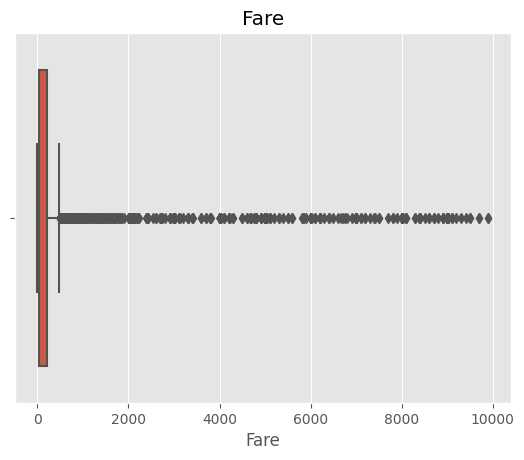

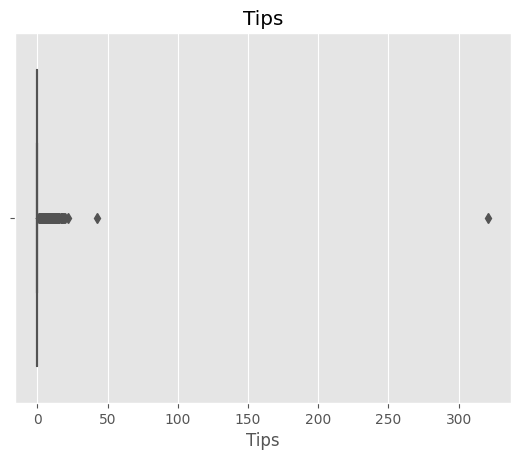

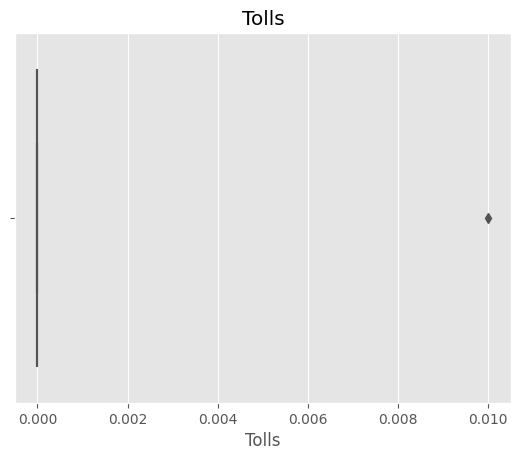

In [ ]:
for feat in financial_details_columns:
    sns.boxplot(x=taxi_id_data_a[feat])
    plt.title(feat)
    plt.show()

In [ ]:
for feat in financial_details_columns:
    sns.boxplot(x=taxi_id_data_b[feat])
    plt.title(feat)
    plt.show()

In [ ]:
taxi_id_data_a.groupby('Payment Type').size()

In [ ]:
cash_id_data_a = taxi_id_data_a[taxi_id_data_a['Payment Type'] == 'Cash']

In [ ]:
cash_id_data_a['Trip Total'].sum()

In [ ]:
del taxi_id_data_a, taxi_id_data_b

### Because of huge amount of outliers I decided to contact the database owner and ask about it. He told me that all outliers are probably errors.
I do not think that someone is laundering money this way ⛔

I decided to delete outliers from Fare, Tolls, Extras and Trip Total.

In [ ]:
df.shape

In [ ]:
df_to_plot = df[financial_details_columns].to_pandas()

In [ ]:
custom_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
for column in financial_details_columns:
  sns.histplot(df_to_plot[column], bins=custom_bins)
  counts, bins, _ = plt.hist(df_to_plot[column], bins=custom_bins)
  for i, count in enumerate(counts):
    plt.text(bins[i], count, str(int(count)), ha='center', va='bottom')
  plt.title(f'Distribution of {column}')
  plt.show()

In [ ]:
df = df[~(df[financial_details_columns] > 100).any(axis=1)]

In [ ]:
df_to_plot = df[financial_details_columns].to_pandas()

In [1]:
for column in financial_details_columns:
  sns.histplot(df_to_plot[column], bins=20)
  counts, bins, _ = plt.hist(df_to_plot[column], bins=50)
  for i, count in enumerate(counts):
    plt.text(bins[i], count, str(int(count)), ha='center', va='bottom')
  plt.title(f'Distribution of {column}')
  plt.show()

NameError: ignored

In [96]:
df.shape

(6363999, 19)

### 3. Other info - TO DO

In [ ]:
df.groupby(df['Payment Type'].str.strip("'"), )['Trip ID'].nunique()

Payment Type
Cash           1753340
Credit Card    1992058
Dispute           2099
Mobile          883607
No Charge         1827
Prcard          544060
Prepaid              1
Unknown         290834
Name: Trip ID, dtype: int64

### 4. Correlations